# Tweet and Speech Text Generation


In the first script, we completed a sentiment analysis on Tweets to understand, in general, what is the sentiment of the Twitter community towards a specific topic (GOP Debate). We were able to extract insights such as which are the more-mentioned words and hashtags among negative and positive tweets. Then, in the previous script, we performed language modeling and Tweet generation using LSTMs to generalize and anticipate Twitter opinions on certain topics.

However, as mentioned in the previous conclusion, considering that deep learning for speech modelling is computationally expensive, we considered using a different approach. In this script, we model Tweet Generation through *N-gram probabilities*. This approach is considerably faster and may also address our main objective of Tweet generalization and anticipation.

Once the candidate's campaign team understands the Tweet Sentiment and Tweet Text Generation, the candidate and the campaign organizer have to tailor the campaign and future speeches in a manner that reflects the candidate's audience preference. For this second part of the notebook, we will also use Text Generation techniques based on historical speeches from different politicians that were previously elected. The output may serve as an initial brainstorming or guideline for speech creation. However, it is also important to consider who the speaker was, who the audience was, and in what macroeconomic environment the speeches took place. The Speech Generation output will serve as an initial suggestion that will have to be analyzed by campaign organizers.



# 1. Tweet (Text) Generation

## Importing and Processing Tweets

Considering that Tweets are composed not only by words but also by special characters such as hashtags, usernames, urls, and emojis, we need to remove them to do a proper word counting and subsequent Text Generation. These characters do not add relevant information for our objectives of the Text Generation.

We start by defining two functions. One that deletes special characters and one that deletes words that start with @ and #.


In [3]:
import nltk
from nltk import word_tokenize, WordPunctTokenizer
import pandas

wpt = WordPunctTokenizer()
import re
import string

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

We proceed to import the Tweets, preprocess them with the previously created functions, and tokenize them with the word tokenize function. 

In [4]:
tweets = open('tweets2.txt', encoding='utf8', errors='ignore')
tweets_text = tweets.read()

tweets_clean = strip_links(str(tweets_text))
tweets_clean = strip_all_entities(tweets_clean)

tweets_clean2 = nltk.Text(wpt.tokenize(tweets_clean))
tweets_clean2

<Text: RT How did everyone feel about the Climate...>

## Text Generation Using N-gram Probabilities

To generate text, we create a backoff strategy, similar to what we did in the practice assignment. This means that iteratively first we will try to generate a word based on a 4-gram probability. If it fails, based on a Tri-gram probability, if it fails, on a Bi-gram, and if it fails, it stops.

The parameters for this function are the input training text, the initial words to start the sentence, and the length of the text to be generated.

In [5]:
def generate_text_backoff(text, initialwords, numwords):
   
    #ngrams
    ngrams = list(nltk.ngrams(text, 4,  pad_right=True, pad_left=True))
    ngram_pairs = (((w0, w1, w2), w3) for w0, w1, w2, w3 in ngrams)
    cpdNgram = nltk.ConditionalProbDist(nltk.ConditionalFreqDist(ngram_pairs), nltk.MLEProbDist)

    #trigram 
    trigrams = list(nltk.ngrams(text, 3,  pad_right=True, pad_left=True))
    trigram_pairs = (((w0, w1), w2) for w0, w1, w2 in trigrams)
    cpd3gram = nltk.ConditionalProbDist(nltk.ConditionalFreqDist(trigram_pairs), nltk.MLEProbDist)

    #bigram
    bigrams = list(nltk.ngrams(text, 2))
    cpd2gram = nltk.ConditionalProbDist(nltk.ConditionalFreqDist(bigrams), nltk.MLEProbDist)
    
    
    word = initialwords
    for i in range(numwords):
        #try n-gram
        if (word[i],word[i+1], word[i+2]) in cpdNgram:
            w = cpdNgram[(word[i],word[i+1], word[i+2])].max()
        #try 3-gram
        elif (word[i+1],word[i+2]) in cpd3gram:
            w = cpd3gram[(word[i+1],word[i+2])].max()
        #try 2-gram
        elif word[i+2] in cpd2gram:
            w = cpd2gram[word[i+2]].max()
        #at least we tried...
        else:
            break
            
        word += [w]
    
    return " ".join(word)

## Generating Tweet-Related Opinions
As an example, we will see which text is generated for a general topic such as the elections. The input words are "The elections will", and the expected outpus is the next 15 words. 

As we can see, the result is a negative reaction towards Hillary in debating.

As another example, we imputed the words "Trump is a", generating the subsequent words "Pure joke...". 

In [6]:
print("Tweets: " + generate_text_backoff(tweets_clean2, ["the","elections","will"], 15))

Tweets: the elections will be how to get Hillary sober long enough for her to debate RT A big


In [7]:
print("Tweets: " + generate_text_backoff(tweets_clean2, ["Trump","is","a"], 15))

Tweets: Trump is a pure JOKE Americans cannot let this CLOWN become president … RT Take a break from


# 2. Speech (Text) Generation

For this second part of the notebook, we will also use Text Generation techniques based on historical speeches from different politicians that were previously elected. The output may serve as an initial brainstorming or guideline for speech creation. 

## Importing Speeches

For our speech generation analysis, we will focus our project on two specific topics: Education and Economy. For this, we searched for different speeches related to these topics that will be analyzed individually and in a merged text database. This way, we will be able to generate text based on the speaker and on the topic.

### Education Speeches:
* **education_speech1:** Full text of Obama’s education speech
https://www.denverpost.com/2008/05/28/full-text-of-obamas-education-speech/
* **education_speech2:** Compilation small Education Speeches in English.
https://www.indiacelebrating.com/speech/importance-of-education-speech/
* **education_speech3:** The full text of a speech by the education secretary, Ruth Kelly, to the North of England Education conference in Gateshead
https://www.theguardian.com/education/2006/jan/06/schools.uk
* **educaion_speech4:** Obama Back To School Speech
https://www.huffpost.com/entry/obama-speech-to-schoolchi_n_278763
* **education_speech5:** Full Text of Bush's Campaign Speech on Education
https://archive.nytimes.com/www.nytimes.com/library/politics/camp/110399wh-gop-bush-text.html
* **education_speech6:** Trump quotes about Education
https://fordhaminstitute.org/national/commentary/president-donald-trump-quotes-about-education

### Economy Speeches
* **economy_speech1:** Bill Clinton speech BU Penn
https://www.ibiblio.org/nii/econ-posit.html
* **economy_speech2:** "Transforming the British economy: Coalition strategy for economic growth", Shipley 2010 David cameron
http://www.britishpoliticalspeech.org/speech-archive.htm?speech=351
* **economy_speech3:** Obama's Speech on the Economy
https://www.nytimes.com/2009/01/08/us/politics/08text-obama.html
* **economy_speech4:** Donald Trump's Speech on Jobs and the Economy
https://time.com/4495507/donald-trump-economy-speech-transcript/
* **economy_speech5:** President Bush’s Speech to the Nation on the Economic Crisis
https://www.nytimes.com/2008/09/24/business/economy/24text-bush.html


In [1]:
import nltk
from nltk import word_tokenize, WordPunctTokenizer
import pandas

wpt = WordPunctTokenizer()

education_speech1 = open('education_speech1.txt')
education_text1 = education_speech1.read()
education_text1 = nltk.Text(wpt.tokenize(education_text1))
print(education_text1)

education_speech2 = open('education_speech2.txt')
education_text2 = education_speech2.read()
education_text2 = nltk.Text(wpt.tokenize(education_text2))
print(education_text2)

education_speech3 = open('education_speech3.txt')
education_text3 = education_speech3.read()
education_text3 = nltk.Text(wpt.tokenize(education_text3))
print(education_text3)

education_speech4 = open('education_speech4.txt')
education_text4 = education_speech4.read()
education_text4 = nltk.Text(wpt.tokenize(education_text4))
print(education_text4)

education_speech5 = open('education_speech5.txt')
education_text5 = education_speech5.read()
education_text5 = nltk.Text(wpt.tokenize(education_text5))
print(education_text5)

education_speech6 = open('education_speech6.txt')
education_text6 = education_speech6.read()
education_text6 = nltk.Text(wpt.tokenize(education_text6))
print(education_text6)

filenames = ['education_speech1.txt','education_speech2.txt','education_speech3.txt','education_speech4.txt','education_speech5.txt','education_speech6.txt']

education_complete = ''.join([open(f).read() for f in filenames])
education_complete = nltk.Text(wpt.tokenize(education_complete))


<Text: “ It ’ s an honor to be...>
<Text: Good morning to the Excellencies , my respected...>
<Text: I am delighted to be here and my...>
<Text: Hello everyone - how ’ s everybody doing...>
<Text: It is a pleasure to be here ,...>
<Text: 1 . School choice : “ As president...>


In [2]:
economy_speech1 = open('economy_speech1.txt')
economy_text1 = economy_speech1.read()
economy_text1 = nltk.Text(wpt.tokenize(economy_text1))
print(economy_text1)

economy_speech2 = open('economy_speech2.txt')
economy_text2 = economy_speech2.read()
economy_text2 = nltk.Text(wpt.tokenize(economy_text2))
print(economy_text2)

economy_speech3 = open('economy_speech3.txt')
economy_text3 = economy_speech3.read()
economy_text3 = nltk.Text(wpt.tokenize(economy_text3))
print(economy_text3)

economy_speech4 = open('economy_speech4.txt')
economy_text4 = economy_speech4.read()
economy_text4 = nltk.Text(wpt.tokenize(economy_text4))
print(economy_text4)

economy_speech5 = open('economy_speech5.txt')
economy_text5 = economy_speech5.read()
economy_text5 = nltk.Text(wpt.tokenize(economy_text5))
print(economy_text5)

filenames_economy = ['economy_speech1.txt','economy_speech2.txt','economy_speech3.txt','economy_speech4.txt','economy_speech5.txt']

economy_complete = ''.join([open(f).read() for f in filenames_economy])
economy_complete = nltk.Text(wpt.tokenize(economy_complete))

<Text: As many of you know , I '...>
<Text: This is my first major speech as Prime...>
<Text: Let me begin by thanking George Mason University...>
<Text: Thank you for the opportunity to speak with...>
<Text: Good evening . This is an extraordinary period...>


## Generating Speeches

### Education

To generate text related to the education speech, we found interesting results. If we want to analyze how we can include **women's role** in the speech, we can analyze the different outputs, by imputing "womens role is". In the following examples we are getting the next 5 words.

* **Compiled text:** From the compiled we can see a message of progress regardin women's role.
* **Barak Obama:** An obama based speech generates words related with value.
* **Ruth Kelly:** Similar to the text generated with the compiled file, Ruth Kelly generates text related with progress.
* **George Bush:** As expected, for George gush the text generated makes no sense at all.
* **Donald Trump:** For Donald Trump the text generated may be interpreted as negative and sexist.

In [8]:
print("Speech Obama Education: " + generate_text_backoff(education_text1, ["womens","role","is"], 5) + "\n")
print("Speech Multiple personalities: " + generate_text_backoff(education_text2, ["womens","role","is"], 5)+ "\n")
print("Speech Ruth Kelly (England Ed secretary): " + generate_text_backoff(education_text3, ["womens","role","is"], 5)+ "\n")
print("Speech Obama back to school: " + generate_text_backoff(education_text4, ["womens","role","is"], 5)+ "\n")
print("Speech Education Bush Campaign: " + generate_text_backoff(education_text5, ["womens","role","is"], 5)+ "\n")
print("Speech Trump quotes: " + generate_text_backoff(education_text6, ["womens","role","is"], 5)+ "\n")
print("Speech Education Complete: " + generate_text_backoff(education_complete, ["womens","role","is"], 5)+ "\n")

Speech Obama Education: womens role is the currency of the Information

Speech Multiple personalities: womens role is a continuous , slow and

Speech Ruth Kelly (England Ed secretary): womens role is a community determined to move

Speech Obama back to school: womens role is the first day of school

Speech Education Bush Campaign: womens role is a pleasure to be here

Speech Trump quotes: womens role is living in poverty . If

Speech Education Complete: womens role is a continuous , slow and



### Economy

For the economy speech generation, as an example we will analyze in general terms, what economy is. 

* **Compiled text:** From the compiled results we can see that economy is "investing in ourselves" influenced by Bill Clinton.
* **Bill Clinton:** Relates economy with investing with ourselves.
* **Dave Cameron:** For the UK primer minister, Economy is dependant of other things.
* **Barak Obama:** An obama based speech generates words related with uncertainty.
* **Donald Trump:** For Donald Trump, economy is something bold and ambitious.
* **George Bush:** As expected for Geourge Bush, considering the recesion in his presidential period, the economy is in danger.

In [9]:
print("Speech Bill CLinton: " + generate_text_backoff(economy_text1, ["the","economy","is"], 5) + "\n")
print("Speech David Cameron: " + generate_text_backoff(economy_text2, ["the","economy","is"], 5)+ "\n")
print("Speech Barak Obama: " + generate_text_backoff(economy_text3, ["the","economy","is"], 5)+ "\n")
print("Speech Donald Trump: " + generate_text_backoff(economy_text4, ["the","economy","is"], 5)+ "\n")
print("Speech George Bush : " + generate_text_backoff(economy_text5, ["the","economy","is"], 5)+ "\n")

print("Speech Economy Complete: " + generate_text_backoff(economy_complete, ["the","economy","is"], 5)+ "\n")

Speech Bill CLinton: the economy is investing in ourselves . The

Speech David Cameron: the economy is heavily reliant on just a

Speech Barak Obama: the economy is now watching and waiting for

Speech Donald Trump: the economy is a bold , ambitious ,

Speech George Bush : the economy is in danger . So I

Speech Economy Complete: the economy is investing in ourselves . The



# Overall Conclusion

Through text generation, we can extract insights related to the topic or keyword we would like to explore. LSTM is a good approach for generating accurate results. However, N-grams probability is also a good approach for generating Tweets and revealing the most probable words that compliment an initial word for forming a sentence. This approach is considerably less computationally expensive versus LSTM but less advanced in terms of the approach and decisions made.

N-gram probability is also a good approach for speech generation where we can analyze which may be the most probable subsequent words for different interlocutors. It is important to consider that text generation strongly depends on the input text for training the model. As subsequent steps to enhance the speech generation tool, we would input a bigger repository of speeches of each political celebrity, and increase the repertoire of speakers for a better speech recommender. In addition, we did not model a RNN for speech generation as the size of the data was too big and the tools we were using did not permit us to model a RNN without crashing. 

As a general conclusion, we can observe from the following image that through the combination of multiple NLP techniques we can thoroughly understand the context of an event and take actions to better transmit persuasive messages to reach a specific goal.

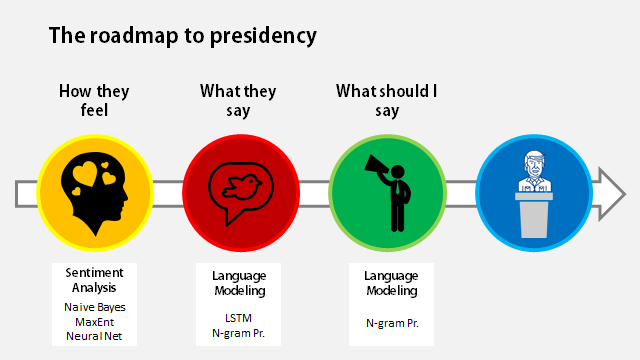